# S&P 500 Index vs S&P 500 Sectors Portfolio

The goal of the project is to test how well performs a portfolio consisting of different sectors of the S&P 500 index against the benchmark S&P 500 index.

The original data was found on the official site of [S&P 500 Global](https://www.spglobal.com/spdji/en/index-family/equity/us-equity/sp-sectors) and contains 11 datasets in .xls format for the last 10+ years.

The data was previously merged from two groups of datasets ([old data](https://github.com/evgenyzorin/SP-500-Index-Backtest/tree/main/old_data) and [new data](https://github.com/evgenyzorin/SP-500-Index-Backtest/tree/main/new_data)) and cleaned, and is loaded into this project as one final dataset in .csv format.

In [1]:
# Import libraries
import os
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('fast')

import warnings as wn
wn.filterwarnings('ignore')

In [2]:
# Load the data from all the datasets into the dataframe
dir_path = os.path.abspath('sp-500-compound-data.csv')
df = pd.read_csv(dir_path)

In [3]:
# Quick look at the dataframe
df.head()

,date,communication_services,consumer_discretionary,consumer_staples,energy,financials,health_care,industrials,information_technology,materials,utilities,sp_500
0,2011-02-28,96.25,118.58,181.26,334.50,87.75,133.37,148.66,58.85,187.83,157.55,2095.78
1,2011-03-01,94.51,116.51,180.42,329.39,85.83,132.47,145.39,57.86,183.51,156.06,2062.79
2,2011-03-02,94.84,116.97,179.90,331.03,85.27,132.84,146.05,58.14,183.94,156.45,2066.36
3,2011-03-03,96.06,118.93,181.79,336.14,87.10,135.48,149.51,59.11,187.60,157.94,2101.99
4,2011-03-04,95.23,118.11,180.97,333.99,85.95,135.40,147.78,58.71,186.26,157.03,2086.50


In [4]:
# Quick look at the summary of the data (types, missing values)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2657 entries, 0 to 2656
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    2657 non-null   object 
 1   communication_services  2657 non-null   float64
 2   consumer_discretionary  2657 non-null   float64
 3   consumer_staples        2657 non-null   float64
 4   energy                  2657 non-null   float64
 5   financials              2657 non-null   float64
 6   health_care             2657 non-null   float64
 7   industrials             2657 non-null   float64
 8   information_technology  2657 non-null   float64
 9   materials               2657 non-null   float64
 10  utilities               2657 non-null   float64
 11  sp_500                  2657 non-null   float64
dtypes: float64(11), object(1)
memory usage: 249.2+ KB


In [5]:
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

In [6]:
# Define some parameters such as first deposit, monthly payments and instrument factor
deposit = 10000 # One-off amount
payment = 1000 # Recurrent (monthly)

factors = {
    'communication_services': 0,
    'consumer_discretionary': 0.23,
    'consumer_staples': 0,
    'energy': 0,
    'financials': 0,
    'health_care': 0.25,
    'industrials': 0,
    'information_technology': 0.52,
    'materials': 0,
    'utilities': 0,
    'sp_500': 1,
}

In [7]:
# Get the list of the features
columns = df.columns.to_list()
columns.remove('date')
columns

['communication_services',
 'consumer_discretionary',
 'consumer_staples',
 'energy',
 'financials',
 'health_care',
 'industrials',
 'information_technology',
 'materials',
 'utilities',
 'sp_500']

In [8]:
# Create a new dataframe with the prices of the first day of each month
df1 = df[~df['date'].dt.to_period('m').duplicated()]

In [9]:
# Calculate the number of shares to buy for all instruments in each month
for column in columns:
    shares_to_buy = '_'.join([column, 'shares_to_buy'])    
    df1[shares_to_buy] = [(payment * factors[column] / buy_price) for buy_price in df1[column]]
    if deposit:
        df1.loc[0, shares_to_buy] += deposit * factors[column] / df1.loc[0, column]
    df1[shares_to_buy] = df1[shares_to_buy].cumsum()

df1.head()

,date,communication_services,consumer_discretionary,consumer_staples,energy,financials,health_care,industrials,information_technology,materials,utilities,sp_500,communication_services_shares_to_buy,consumer_discretionary_shares_to_buy,consumer_staples_shares_to_buy,energy_shares_to_buy,financials_shares_to_buy,health_care_shares_to_buy,industrials_shares_to_buy,information_technology_shares_to_buy,materials_shares_to_buy,utilities_shares_to_buy,sp_500_shares_to_buy
0,2011-02-28,96.25,118.58,181.26,334.50,87.75,133.37,148.66,58.85,187.83,157.55,2095.78,0.0,21.335807,0.0,0.0,0.0,20.619330,0.0,97.196262,0.0,0.0,5.248643
1,2011-03-01,94.51,116.51,180.42,329.39,85.83,132.47,145.39,57.86,183.51,156.06,2062.79,0.0,23.309887,0.0,0.0,0.0,22.506549,0.0,106.183472,0.0,0.0,5.733423
24,2011-04-01,97.35,118.79,185.01,340.94,86.15,136.61,152.65,57.26,191.88,158.86,2106.12,0.0,25.246076,0.0,0.0,0.0,24.336577,0.0,115.264855,0.0,0.0,6.208230
44,2011-05-02,98.21,122.96,193.77,340.13,85.12,146.11,155.24,58.75,194.08,164.11,2153.28,0.0,27.116603,0.0,0.0,0.0,26.047616,0.0,124.115919,0.0,0.0,6.672637
65,2011-06-01,96.34,119.36,196.18,322.06,79.78,145.99,146.24,56.73,184.03,165.50,2082.83,0.0,29.043547,0.0,0.0,0.0,27.760062,0.0,133.282145,0.0,0.0,7.152753


In [10]:
# Merge two dataframes into a new full dataframe 
df2 = df.merge(df1, how='left')
df2.head()

,date,communication_services,consumer_discretionary,consumer_staples,energy,financials,health_care,industrials,information_technology,materials,utilities,sp_500,communication_services_shares_to_buy,consumer_discretionary_shares_to_buy,consumer_staples_shares_to_buy,energy_shares_to_buy,financials_shares_to_buy,health_care_shares_to_buy,industrials_shares_to_buy,information_technology_shares_to_buy,materials_shares_to_buy,utilities_shares_to_buy,sp_500_shares_to_buy
0,2011-02-28,96.25,118.58,181.26,334.50,87.75,133.37,148.66,58.85,187.83,157.55,2095.78,0.0,21.335807,0.0,0.0,0.0,20.619330,0.0,97.196262,0.0,0.0,5.248643
1,2011-03-01,94.51,116.51,180.42,329.39,85.83,132.47,145.39,57.86,183.51,156.06,2062.79,0.0,23.309887,0.0,0.0,0.0,22.506549,0.0,106.183472,0.0,0.0,5.733423
2,2011-03-02,94.84,116.97,179.90,331.03,85.27,132.84,146.05,58.14,183.94,156.45,2066.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-03-03,96.06,118.93,181.79,336.14,87.10,135.48,149.51,59.11,187.60,157.94,2101.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-03-04,95.23,118.11,180.97,333.99,85.95,135.40,147.78,58.71,186.26,157.03,2086.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Fill all NaN values with the real values using 'ffill' method
df2 = df2.fillna(method="ffill")
df2.head()

,date,communication_services,consumer_discretionary,consumer_staples,energy,financials,health_care,industrials,information_technology,materials,utilities,sp_500,communication_services_shares_to_buy,consumer_discretionary_shares_to_buy,consumer_staples_shares_to_buy,energy_shares_to_buy,financials_shares_to_buy,health_care_shares_to_buy,industrials_shares_to_buy,information_technology_shares_to_buy,materials_shares_to_buy,utilities_shares_to_buy,sp_500_shares_to_buy
0,2011-02-28,96.25,118.58,181.26,334.50,87.75,133.37,148.66,58.85,187.83,157.55,2095.78,0.0,21.335807,0.0,0.0,0.0,20.619330,0.0,97.196262,0.0,0.0,5.248643
1,2011-03-01,94.51,116.51,180.42,329.39,85.83,132.47,145.39,57.86,183.51,156.06,2062.79,0.0,23.309887,0.0,0.0,0.0,22.506549,0.0,106.183472,0.0,0.0,5.733423
2,2011-03-02,94.84,116.97,179.90,331.03,85.27,132.84,146.05,58.14,183.94,156.45,2066.36,0.0,23.309887,0.0,0.0,0.0,22.506549,0.0,106.183472,0.0,0.0,5.733423
3,2011-03-03,96.06,118.93,181.79,336.14,87.10,135.48,149.51,59.11,187.60,157.94,2101.99,0.0,23.309887,0.0,0.0,0.0,22.506549,0.0,106.183472,0.0,0.0,5.733423
4,2011-03-04,95.23,118.11,180.97,333.99,85.95,135.40,147.78,58.71,186.26,157.03,2086.50,0.0,23.309887,0.0,0.0,0.0,22.506549,0.0,106.183472,0.0,0.0,5.733423


In [12]:
# Get the number of years
years = df2['date'].dt.year.iloc[-1] - df2['date'].dt.year.iloc[0]
years

10

In [13]:
# Get the number of months
months = df1.shape[0]
months

128

In [14]:
# Calculate the price change for all features
portfolio_columns = []

for column in columns:
    shares_to_buy = '_'.join([column, 'shares_to_buy'])
    price_change = '_'.join([column, 'change'])
    df2[price_change] = df2[column] * df2[shares_to_buy]
    if price_change != 'sp_500_change':
        portfolio_columns.append(price_change)

In [15]:
# Define column names of the labels
index_column = 'sp_500_change'
portfolio_column = 'portfolio_change'

In [16]:
# Add portfolio change to the dataframe
df2[portfolio_column] = list(map(sum, df2[portfolio_columns].values))
df2.head()

,date,communication_services,consumer_discretionary,consumer_staples,energy,financials,health_care,industrials,information_technology,materials,utilities,sp_500,communication_services_shares_to_buy,consumer_discretionary_shares_to_buy,consumer_staples_shares_to_buy,energy_shares_to_buy,financials_shares_to_buy,health_care_shares_to_buy,industrials_shares_to_buy,information_technology_shares_to_buy,materials_shares_to_buy,utilities_shares_to_buy,sp_500_shares_to_buy,communication_services_change,consumer_discretionary_change,consumer_staples_change,energy_change,financials_change,health_care_change,industrials_change,information_technology_change,materials_change,utilities_change,sp_500_change,portfolio_change
0,2011-02-28,96.25,118.58,181.26,334.50,87.75,133.37,148.66,58.85,187.83,157.55,2095.78,0.0,21.335807,0.0,0.0,0.0,20.619330,0.0,97.196262,0.0,0.0,5.248643,0.0,2530.000000,0.0,0.0,0.0,2750.000000,0.0,5720.000000,0.0,0.0,11000.000000,11000.000000
1,2011-03-01,94.51,116.51,180.42,329.39,85.83,132.47,145.39,57.86,183.51,156.06,2062.79,0.0,23.309887,0.0,0.0,0.0,22.506549,0.0,106.183472,0.0,0.0,5.733423,0.0,2715.834879,0.0,0.0,0.0,2981.442603,0.0,6143.775701,0.0,0.0,11826.847284,11841.053184
2,2011-03-02,94.84,116.97,179.90,331.03,85.27,132.84,146.05,58.14,183.94,156.45,2066.36,0.0,23.309887,0.0,0.0,0.0,22.506549,0.0,106.183472,0.0,0.0,5.733423,0.0,2726.557427,0.0,0.0,0.0,2989.770027,0.0,6173.507073,0.0,0.0,11847.315603,11889.834527
3,2011-03-03,96.06,118.93,181.79,336.14,87.10,135.48,149.51,59.11,187.60,157.94,2101.99,0.0,23.309887,0.0,0.0,0.0,22.506549,0.0,106.183472,0.0,0.0,5.733423,0.0,2772.244805,0.0,0.0,0.0,3049.187317,0.0,6276.505041,0.0,0.0,12051.597459,12097.937163
4,2011-03-04,95.23,118.11,180.97,333.99,85.95,135.40,147.78,58.71,186.26,157.03,2086.50,0.0,23.309887,0.0,0.0,0.0,22.506549,0.0,106.183472,0.0,0.0,5.733423,0.0,2753.130698,0.0,0.0,0.0,3047.386793,0.0,6234.031652,0.0,0.0,11962.786739,12034.549143


In [17]:
# Get the last value of the labels
index_max = df2[index_column].iloc[-1]
portfolio_max = df2[portfolio_column].iloc[-1]

In [18]:
# Calculate the CAGR (Compound Annual Growth Rate) for the labels
index_cagr = ((index_max / (deposit + (payment * months))) ** (1 / years) - 1) * 100
portfolio_cagr = ((portfolio_max / (deposit + (payment * months))) ** (1 / years) - 1) * 100

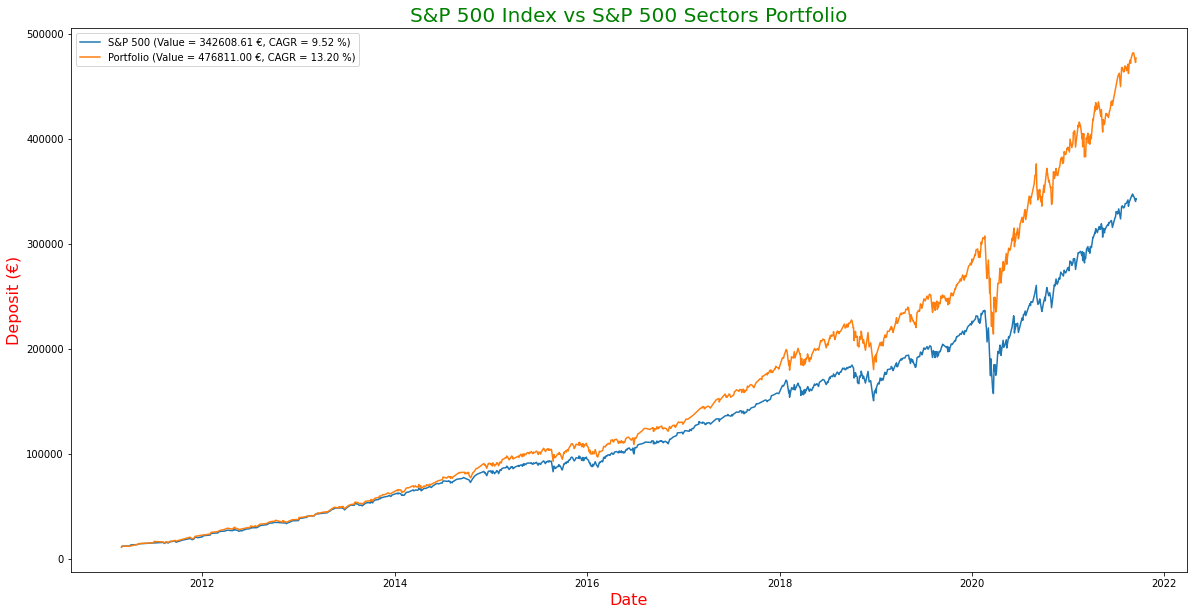

In [19]:
plt.figure(figsize=(20, 10))
plt.plot(df2['date'], df2[index_column], label=f'S&P 500 (Value = {index_max:.2f} €, CAGR = {index_cagr:.2f} %)')
plt.plot(df2['date'], df2[portfolio_column], label=f'Portfolio (Value = {portfolio_max:.2f} €, CAGR = {portfolio_cagr:.2f} %)')
plt.xlabel('Date', size=16, color='red')  # Add an x-label to the axes.
plt.ylabel('Deposit (€)', size=16, color='red')  # Add a y-label to the axes.
plt.title("S&P 500 Index vs S&P 500 Sectors Portfolio", size=20, color='green')  # Add a title to the axes.
plt.legend()
plt.show()